# Elderly Fall Detection using CNN-LSTM with Attention Layer

This notebook trains a deep learning model for detecting elderly falls using accelerometer and gyroscope data. The trained model will be optimized for deployment on ESP32-S3 microcontroller.

## Dataset Structure
- **Falls**: 2,791 samples
- **Walking**: 2,838 samples
- **Running**: Various samples
- **Stand Up**: Various samples
- **Driving**: Various samples

Each sample contains 801 time steps with 9 features:
- AccX, AccY, AccZ (accelerometer)
- GyroX, GyroY, GyroZ (gyroscope)
- Magnitude, Temperature, Altitude

## 1. Setup and Installation

First, let's install required packages and setup the environment for Google Colab.

In [3]:
# Install required packages
!pip install tensorflow==2.13.0
!pip install tensorflow-model-optimization==0.7.0
!pip install numpy==1.26.0 scikit-learn seaborn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.5/58.5 kB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.2/18.2 MB 103.8 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 1.24.3
    Uninstalling numpy-1.24.3:
      Successfully uninstalled numpy-1.24.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.13.0 requires numpy<=1.24.3,>=1.22, but you have numpy 1.26.0 which is incompatible.
ydf 0.13.0 requires protobuf<7.0.0,>=5.29.1, but you have protobuf 4.25.8 which is incompatible.
tf-keras 2.18.0 requires tensorflow<2.19,>=2.18, but you have tensorflow 2.13.0 which is incompatible.
tensorflow-decision-forests 1.11.0 requires tensorflow==2.18.0, but you have tensorflow 2.13.0 which is incompatible.
tensorflow-text 2.18.1 requires tensorflow<2.19,>=2.18.0, but you have tensorflow 2.13.0 which is 

In [2]:
# For ESP32 deployment
!pip install tflite-runtime

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models, optimizers, callbacks
from tensorflow.keras.utils import to_categorical
import glob
import warnings
warnings.filterwarnings('ignore')

print(f"TensorFlow version: {tf.__version__}")
# Check if GPU is available using the recommended method
gpu_devices = tf.config.list_physical_devices('GPU')
print(f"GPU Available: {len(gpu_devices) > 0}")
print(f"GPU Devices: {gpu_devices}")

TensorFlow version: 2.13.0
GPU Available: False
GPU Devices: []


## 2. Mount Google Drive and Upload Dataset

Upload your 'Dataset V4' folder to Google Drive and mount it here.

In [3]:
from google.colab import drive
drive.mount('/content/drive')

# Update this path to where you uploaded your dataset in Google Drive
DATASET_PATH = '/content/drive/MyDrive/Dataset V4'

# Verify dataset exists
if os.path.exists(DATASET_PATH):
    print("Dataset found!")
    categories = os.listdir(DATASET_PATH)
    print(f"Categories: {categories}")

    for category in categories:
        if os.path.isdir(os.path.join(DATASET_PATH, category)):
            count = len(glob.glob(os.path.join(DATASET_PATH, category, '*.csv')))
            print(f"{category}: {count} files")
else:
    print("Dataset not found. Please upload 'Dataset V4' to your Google Drive.")

Mounted at /content/drive
Dataset found!
Categories: ['Falls', 'Running', 'Driving', 'Stand Up', 'Walking']
Falls: 2801 files
Running: 1141 files
Driving: 174 files
Stand Up: 2012 files
Walking: 2848 files


## 3. Data Loading and Preprocessing

In [4]:
def robust_load_sensor_data(dataset_path, sequence_length=801):
    """
    Load and preprocess sensor data from CSV files with robust error handling.

    Args:
        dataset_path: Path to dataset directory
        sequence_length: Number of time steps per sequence

    Returns:
        X: Feature data (samples, time_steps, features)
        y: Labels
        label_encoder: Fitted label encoder
    """

    X = []
    y = []

    # Dynamically get categories from subdirectories
    categories = [d for d in os.listdir(dataset_path) if os.path.isdir(os.path.join(dataset_path, d))]

    print("Loading data...")

    for category in categories:
        category_path = os.path.join(dataset_path, category)
        if not os.path.exists(category_path):
            print(f"Warning: {category} folder not found")
            continue

        csv_files = glob.glob(os.path.join(category_path, '*.csv'))

        print(f"Processing {category}: {len(csv_files)} files")

        for i, file_path in enumerate(csv_files):
            try:
                # Read CSV file, handle potential parsing errors
                df = pd.read_csv(file_path)

                # Check if the DataFrame is empty after reading
                if df.empty:
                    print(f"Warning: Empty DataFrame after reading {file_path}")
                    continue

                # Select relevant sensor features
                feature_columns = ['AccX', 'AccY', 'AccZ','GyroX', 'GyroY', 'GyroZ']

                # Ensure all columns exist and are not all NaN
                available_columns = [col for col in feature_columns if col in df.columns and not df[col].isnull().all()]

                if len(available_columns) < 6:  # At least acc and gyro data
                    # print(f"Warning: Insufficient valid features in {file_path}")
                    continue

                # Extract features
                features = df[available_columns].values

                # Pad or truncate to fixed sequence length
                if len(features) > sequence_length:
                    features = features[:sequence_length]
                elif len(features) < sequence_length:
                    padding = np.zeros((sequence_length - len(features), len(available_columns)))
                    features = np.vstack([features, padding])

                # Handle NaN values
                features = np.nan_to_num(features, nan=0.0)

                X.append(features)
                y.append(category)

                if (i + 1) % 100 == 0:
                    print(f"  Processed {i + 1}/{len(csv_files)} files")

            except Exception as e:
                print(f"Error processing {file_path}: {str(e)}")
                continue

    # Convert to numpy arrays
    X = np.array(X)
    y = np.array(y)

    # Encode labels
    label_encoder = LabelEncoder()
    y_encoded = label_encoder.fit_transform(y)

    print(f"\nData loading completed:")
    print(f"Total samples: {len(X)}")
    print(f"Input shape: {X.shape}")
    print(f"Classes: {label_encoder.classes_}")
    print(f"Class distribution:")
    unique, counts = np.unique(y, return_counts=True)
    for cls, count in zip(unique, counts):
        print(f"  {cls}: {count} samples")

    return X, y_encoded, label_encoder

In [5]:
# Load the dataset using the robust loader
X, y, label_encoder = robust_load_sensor_data(
    DATASET_PATH,
    sequence_length=301
)

print(f"\nFinal dataset shape: {X.shape}")
print(f"Number of classes: {len(label_encoder.classes_)}")
print(f"Features per timestep: {X.shape[2]}")

Loading data...
Processing Falls: 2801 files
  Processed 100/2801 files
  Processed 200/2801 files
  Processed 300/2801 files
  Processed 400/2801 files
  Processed 500/2801 files
  Processed 600/2801 files
  Processed 700/2801 files
  Processed 800/2801 files
  Processed 900/2801 files
  Processed 1000/2801 files
  Processed 1100/2801 files
  Processed 1200/2801 files
  Processed 1300/2801 files
  Processed 1400/2801 files
  Processed 1500/2801 files
  Processed 1600/2801 files
  Processed 1700/2801 files
  Processed 1800/2801 files
  Processed 1900/2801 files
  Processed 2000/2801 files
  Processed 2100/2801 files
  Processed 2200/2801 files
  Processed 2300/2801 files
  Processed 2400/2801 files
  Processed 2500/2801 files
  Processed 2600/2801 files
  Processed 2700/2801 files
  Processed 2800/2801 files
Processing Running: 1141 files
  Processed 100/1141 files
  Processed 200/1141 files
Error processing /content/drive/MyDrive/Dataset V4/Running/accelerometer_data_20241219_062006.c

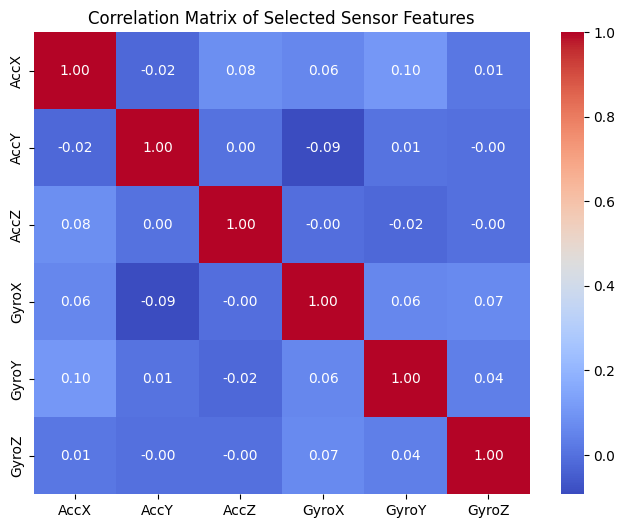

In [6]:
# Create a DataFrame for correlation matrix calculation
# We need to reshape X to 2D array first
X_reshaped = X.reshape(-1, X.shape[-1])
df_for_corr = pd.DataFrame(X_reshaped, columns=['AccX', 'AccY', 'AccZ', 'GyroX', 'GyroY', 'GyroZ'])


# Calculate and visualize the correlation matrix for selected features
correlation_matrix = df_for_corr.corr()

plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix of Selected Sensor Features')
plt.show()

## 4. Data Preprocessing and Normalization

In [17]:
from sklearn.preprocessing import RobustScaler

# Normalize the data using RobustScaler
def normalize_data(X_train, X_val, X_test):
    """
    Normalize the sensor data using RobustScaler
    """
    # Reshape for scaling (samples * timesteps, features)
    original_shape_train = X_train.shape
    original_shape_val = X_val.shape
    original_shape_test = X_test.shape

    # Check if any of the arrays are empty before reshaping
    if X_train.size == 0 or X_val.size == 0 or X_test.size == 0:
        print("Warning: One or more data splits are empty. Skipping normalization.")
        return X_train, X_val, X_test, None # Return original arrays and None for scaler

    X_train_reshaped = X_train.reshape(-1, X_train.shape[-1])
    X_val_reshaped = X_val.reshape(-1, X_val.shape[-1])
    X_test_reshaped = X_test.reshape(-1, X_test.shape[-1])

    # Fit scaler on training data
    scaler = RobustScaler()
    X_train_scaled = scaler.fit_transform(X_train_reshaped)
    X_val_scaled = scaler.transform(X_val_reshaped)
    X_test_scaled = scaler.transform(X_test_reshaped)

    # Reshape back to original shape
    X_train_scaled = X_train_scaled.reshape(original_shape_train)
    X_val_scaled = X_val_scaled.reshape(original_shape_val)
    X_test_scaled = X_test_scaled.reshape(original_shape_test)

    return X_train_scaled, X_val_scaled, X_test_scaled, scaler

# Split the data sequentially (time series split)
def time_series_split(X, y, train_ratio=0.8, val_ratio=0.15, test_ratio=0.05):
    """
    Perform a sequential time series split of the data, stratified by class.
    Maintains temporal order within each class.
    """
    if not np.isclose(train_ratio + val_ratio + test_ratio, 1.0):
        raise ValueError("Train, validation, and test ratios must sum to 1.0")

    total_samples = len(X)
    X_train, X_val, X_test = [], [], []
    y_train, y_val, y_test = [], [], []

    unique_classes = np.unique(y)
    for class_label in unique_classes:
        class_indices = np.where(y == class_label)[0]
        class_samples = len(class_indices)

        # Calculate split indices, ensuring at least 1 sample per split if possible
        train_end = max(1, int(train_ratio * class_samples)) if class_samples > 0 else 0
        val_end = max(train_end + 1, train_end + int(val_ratio * class_samples)) if class_samples > train_end else train_end
        test_start = max(val_end + 1, val_end + int(test_ratio * class_samples)) if class_samples > val_end else val_end


        train_indices = class_indices[:train_end]
        val_indices = class_indices[train_end:val_end]
        test_indices = class_indices[val_end:]

        X_train.extend(X[train_indices])
        y_train.extend(y[train_indices])
        X_val.extend(X[val_indices])
        y_val.extend(y[val_indices])
        X_test.extend(X[test_indices])
        y_test.extend(y[test_indices])

    # Convert back to numpy arrays
    X_train = np.array(X_train)
    y_train = np.array(y_train)
    X_val = np.array(X_val)
    y_val = np.array(y_val)
    X_test = np.array(X_test)
    y_test = np.array(y_test)

    # Shuffle within each set after splitting to mix classes, but not the temporal order
    # within each class's sequence
    if len(X_train) > 0:
        train_perm = np.random.permutation(len(X_train))
        X_train = X_train[train_perm]
        y_train = y_train[train_perm]

    if len(X_val) > 0:
        val_perm = np.random.permutation(len(X_val))
        X_val = X_val[val_perm]
        y_val = y_val[val_perm]

    if len(X_test) > 0:
        test_perm = np.random.permutation(len(X_test))
        X_test = X_test[test_perm]
        y_test = y_test[test_perm]


    return X_train, X_val, X_test, y_train, y_val, y_test

# Split the data using sequential time series split
X_train, X_val, X_test, y_train, y_val, y_test = time_series_split(
    X, y, train_ratio=0.95, val_ratio=0.025, test_ratio=0.025
)

print(f"Training set: {X_train.shape}")
print(f"Validation set: {X_val.shape}")
print(f"Test set: {X_test.shape}")

# Normalize the data using RobustScaler
X_train_scaled, X_val_scaled, X_test_scaled, scaler = normalize_data(X_train, X_val, X_test)

# Convert labels to categorical
num_classes = len(label_encoder.classes_)
y_train_cat = to_categorical(y_train, num_classes)
y_val_cat = to_categorical(y_val, num_classes)
y_test_cat = to_categorical(y_test, num_classes)

print(f"\nNormalized data shapes:")
print(f"X_train: {X_train_scaled.shape}")
print(f"y_train: {y_train_cat.shape}")
print(f"Number of classes: {num_classes}")

Training set: (8491, 301, 6)
Validation set: (222, 301, 6)
Test set: (228, 301, 6)

Normalized data shapes:
X_train: (8491, 301, 6)
y_train: (8491, 5)
Number of classes: 5


## 5. CNN-LSTM Model with Attention Layer

We'll create a hybrid model combining:
- **CNN layers**: For extracting local temporal patterns
- **LSTM layers**: For capturing long-term dependencies
- **Attention mechanism**: For focusing on important time steps
- **Optimization for ESP32**: Reduced complexity for deployment

In [18]:
# Custom Attention Layer
class AttentionLayer(layers.Layer):
    def __init__(self, **kwargs):
        super(AttentionLayer, self).__init__(**kwargs)

    def build(self, input_shape):
        self.W = self.add_weight(
            name='attention_weight',
            shape=(input_shape[-1], 1),
            initializer='random_normal',
            trainable=True
        )
        self.b = self.add_weight(
            name='attention_bias',
            shape=(input_shape[1], 1),
            initializer='zeros',
            trainable=True
        )
        super(AttentionLayer, self).build(input_shape)

    def call(self, inputs):
        # inputs shape: (batch_size, time_steps, features)
        # Compute attention scores
        attention_scores = tf.nn.tanh(tf.tensordot(inputs, self.W, axes=1) + self.b)
        attention_weights = tf.nn.softmax(attention_scores, axis=1)

        # Apply attention weights
        weighted_input = inputs * attention_weights
        output = tf.reduce_sum(weighted_input, axis=1)

        return output

    def get_config(self):
        return super(AttentionLayer, self).get_config()

**Latih Model**

In [19]:
def create_cnn_lstm_attention_model(input_shape, num_classes, esp32_optimized=True):
    """
    Create CNN-LSTM model with attention layer

    Args:
        input_shape: Shape of input data (time_steps, features)
        num_classes: Number of output classes
        esp32_optimized: If True, use smaller model for ESP32 deployment
    """

    model = models.Sequential()

    # Input layer
    model.add(layers.Input(shape=input_shape))

    if esp32_optimized:
        # Optimized for ESP32 - smaller model
        # CNN layers for feature extraction
        model.add(layers.Conv1D(filters=16, kernel_size=3, activation='relu', padding='same'))
        model.add(layers.BatchNormalization())
        model.add(layers.MaxPooling1D(pool_size=2))
        model.add(layers.Dropout(0.3))

        model.add(layers.Conv1D(filters=32, kernel_size=3, activation='relu', padding='same'))
        model.add(layers.BatchNormalization())
        model.add(layers.MaxPooling1D(pool_size=2))
        model.add(layers.Dropout(0.3))

        # LSTM layers
        model.add(layers.LSTM(32, return_sequences=True, dropout=0.3, recurrent_dropout=0.2))
        model.add(layers.LSTM(16, return_sequences=True, dropout=0.3, recurrent_dropout=0.2))

        # Attention layer
        model.add(AttentionLayer())

        # Dense layers
        model.add(layers.Dense(32, activation='relu'))
        model.add(layers.Dropout(0.5))

    else:
        # Full model for better accuracy
        # CNN layers
        model.add(layers.Conv1D(filters=32, kernel_size=5, activation='relu', padding='same'))
        model.add(layers.BatchNormalization())
        model.add(layers.MaxPooling1D(pool_size=2))
        model.add(layers.Dropout(0.3))

        model.add(layers.Conv1D(filters=64, kernel_size=3, activation='relu', padding='same'))
        model.add(layers.BatchNormalization())
        model.add(layers.MaxPooling1D(pool_size=2))
        model.add(layers.Dropout(0.3))

        model.add(layers.Conv1D(filters=128, kernel_size=3, activation='relu', padding='same'))
        model.add(layers.BatchNormalization())
        model.add(layers.MaxPooling1D(pool_size=2))
        model.add(layers.Dropout(0.3))

        # LSTM layers
        model.add(layers.LSTM(64, return_sequences=True, dropout=0.3, recurrent_dropout=0.2))
        model.add(layers.LSTM(32, return_sequences=True, dropout=0.3, recurrent_dropout=0.2))

        # Attention layer
        model.add(AttentionLayer())

        # Dense layers
        model.add(layers.Dense(64, activation='relu'))
        model.add(layers.Dropout(0.5))
        model.add(layers.Dense(32, activation='relu'))
        model.add(layers.Dropout(0.5))

    # Output layer
    model.add(layers.Dense(num_classes, activation='softmax'))

    return model

# Create the model
input_shape = (X_train_scaled.shape[1], X_train_scaled.shape[2])
print(f"Input shape: {input_shape}")

# Create ESP32-optimized model
model = create_cnn_lstm_attention_model(input_shape, num_classes, esp32_optimized=True)

# Compile the model
model.compile(
    optimizer=optimizers.Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy', 'precision', 'recall']
)

# Print model summary
model.summary()

# Calculate model size
param_count = model.count_params()
print(f"\nTotal parameters: {param_count:,}")
print(f"Estimated model size: ~{param_count * 4 / 1024 / 1024:.2f} MB (32-bit floats)")

Input shape: (301, 6)
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_2 (Conv1D)           (None, 301, 16)           304       
                                                                 
 batch_normalization_2 (Bat  (None, 301, 16)           64        
 chNormalization)                                                
                                                                 
 max_pooling1d_2 (MaxPoolin  (None, 150, 16)           0         
 g1D)                                                            
                                                                 
 dropout_3 (Dropout)         (None, 150, 16)           0         
                                                                 
 conv1d_3 (Conv1D)           (None, 150, 32)           1568      
                                                                 
 batch_normalization_3 (Bat  (No

## 6. Model Training

In [20]:
# Create callbacks for training
early_stopping = callbacks.EarlyStopping(
    monitor='val_loss',
    patience=50,  # Increased patience
    min_delta=0.001, # Added min_delta
    restore_best_weights=True
)

reduce_lr = callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=5,
    min_lr=1e-7
)

model_checkpoint = callbacks.ModelCheckpoint(
    'best_fall_detection_model.h5',
    monitor='val_accuracy',
    save_best_only=True,
    mode='max'
)

callbacks_list = [early_stopping, reduce_lr, model_checkpoint]

# Train the model
print("Starting model training...")
print(f"Training samples: {len(X_train_scaled)}")
print(f"Validation samples: {len(X_val_scaled)}")

# Training parameters
EPOCHS = 100
BATCH_SIZE = 32

# Use explicit metric objects to avoid potential type errors
model.compile(
    optimizer=optimizers.Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()]
)

# Start training
history = model.fit(
    X_train_scaled, y_train_cat,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=(X_val_scaled, y_val_cat),
    callbacks=callbacks_list,
    verbose=1
)

print("\nTraining completed!")

Starting model training...
Training samples: 8491
Validation samples: 222
Epoch 1/100
266/266 [==============================] - 60s 198ms/step - loss: 0.7980 - accuracy: 0.7393 - precision_1: 0.8553 - recall_1: 0.5575 - val_loss: 0.4972 - val_accuracy: 0.8604 - val_precision_1: 0.8762 - val_recall_1: 0.8288 - lr: 0.0010
Epoch 2/100
266/266 [==============================] - 54s 203ms/step - loss: 0.4365 - accuracy: 0.8750 - precision_1: 0.9073 - recall_1: 0.8338 - val_loss: 0.3734 - val_accuracy: 0.8919 - val_precision_1: 0.9005 - val_recall_1: 0.8559 - lr: 0.0010
Epoch 3/100
266/266 [==============================] - 52s 196ms/step - loss: 0.3646 - accuracy: 0.8954 - precision_1: 0.9213 - recall_1: 0.8608 - val_loss: 0.3000 - val_accuracy: 0.9234 - val_precision_1: 0.9426 - val_recall_1: 0.8874 - lr: 0.0010
Epoch 4/100
266/266 [==============================] - 52s 196ms/step - loss: 0.3311 - accuracy: 0.9040 - precision_1: 0.9280 - recall_1: 0.8778 - val_loss: 0.3104 - val_accuracy:

## 7. Model Evaluation and Visualization

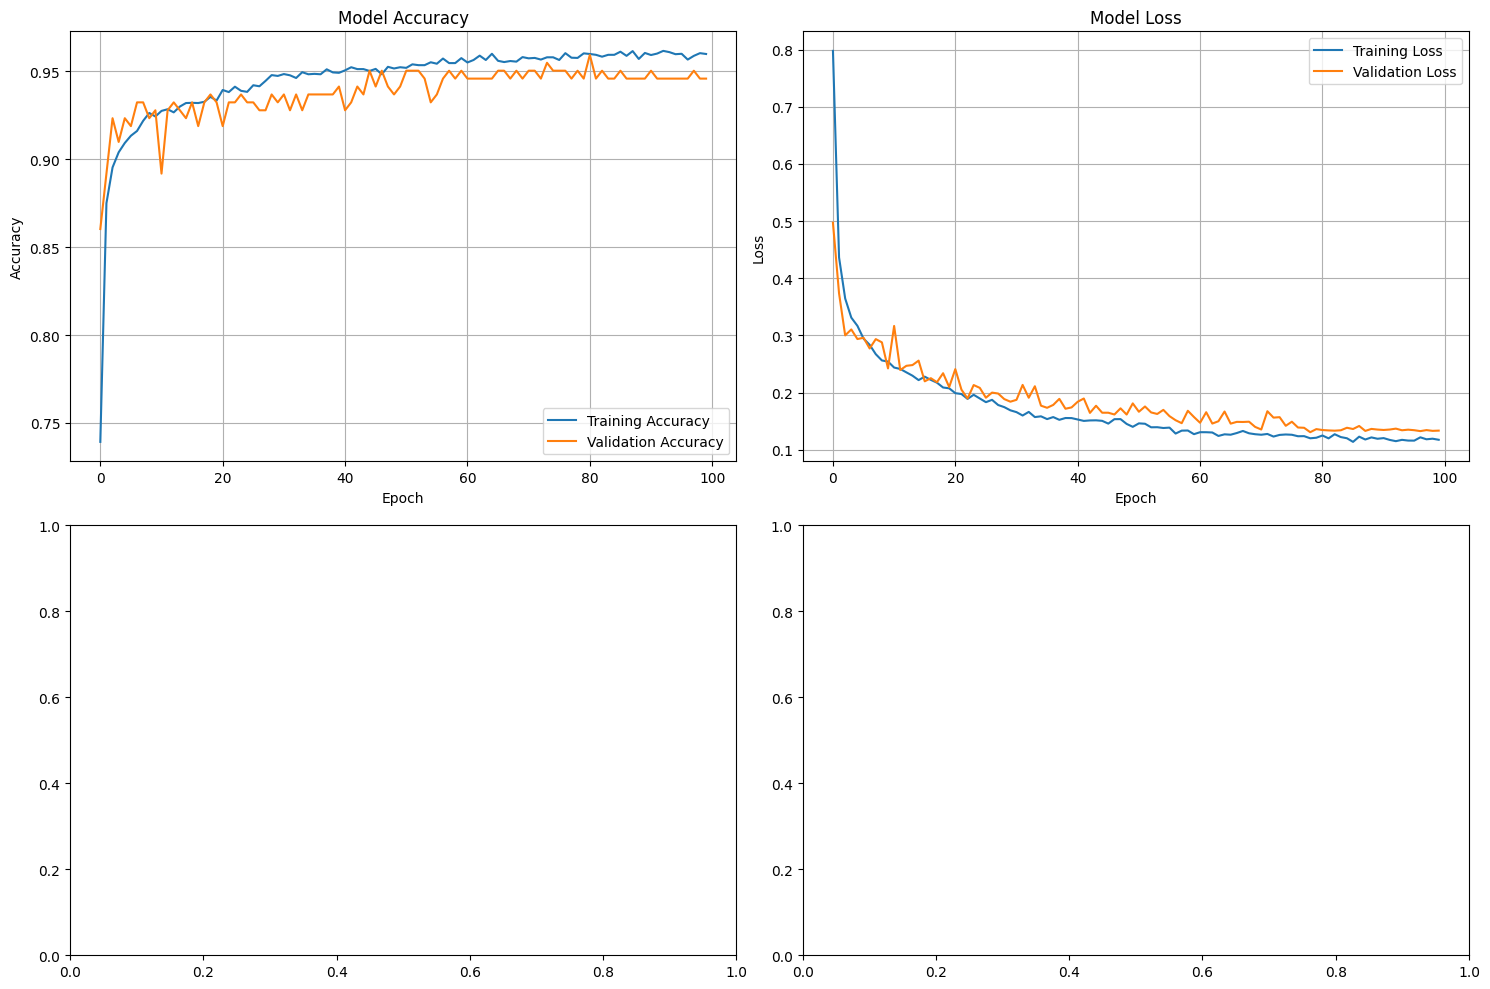

Test Results:
Test Accuracy: 0.9474
Test Precision: 0.9515
Test Recall: 0.9474
Test Loss: 0.2352
8/8 [==============================] - 0s 22ms/step

Classification Report:
              precision    recall  f1-score   support

     Driving       1.00      0.60      0.75         5
       Falls       0.94      0.92      0.93        71
     Running       1.00      0.97      0.98        29
    Stand Up       0.87      0.94      0.91        51
     Walking       0.99      1.00      0.99        72

    accuracy                           0.95       228
   macro avg       0.96      0.88      0.91       228
weighted avg       0.95      0.95      0.95       228



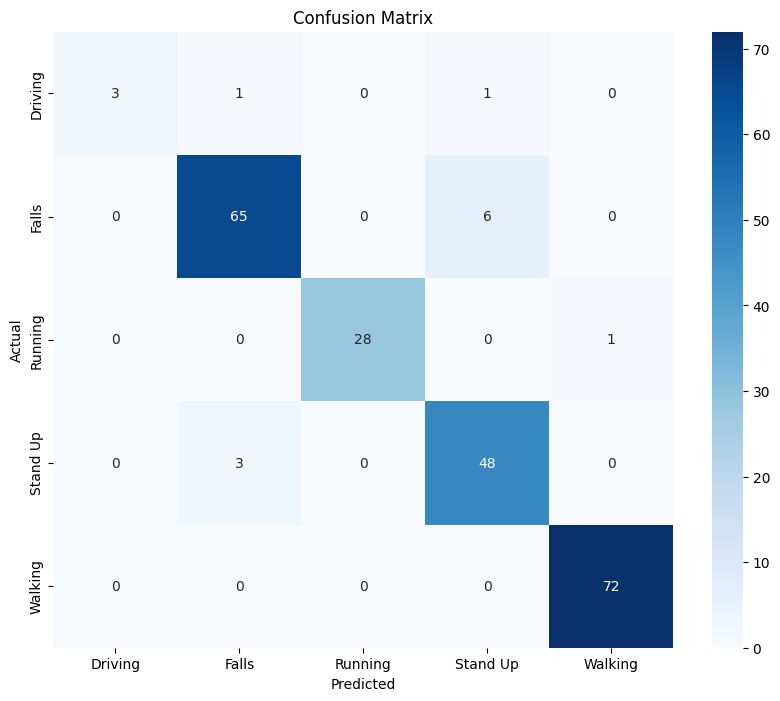

In [26]:
# Plot training history
def plot_complete_training_history(history):
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))

    # Accuracy
    axes[0, 0].plot(history.history['accuracy'], label='Training Accuracy')
    axes[0, 0].plot(history.history['val_accuracy'], label='Validation Accuracy')
    axes[0, 0].set_title('Model Accuracy')
    axes[0, 0].set_xlabel('Epoch')
    axes[0, 0].set_ylabel('Accuracy')
    axes[0, 0].legend()
    axes[0, 0].grid(True)

    # Loss
    axes[0, 1].plot(history.history['loss'], label='Training Loss')
    axes[0, 1].plot(history.history['val_loss'], label='Validation Loss')
    axes[0, 1].set_title('Model Loss')
    axes[0, 1].set_xlabel('Epoch')
    axes[0, 1].set_ylabel('Loss')
    axes[0, 1].legend()
    axes[0, 1].grid(True)

    # Precision
    if 'precision' in history.history:
        axes[1, 0].plot(history.history['precision'], label='Training Precision')
        axes[1, 0].plot(history.history['val_precision'], label='Validation Precision')
        axes[1, 0].set_title('Model Precision')
        axes[1, 0].set_xlabel('Epoch')
        axes[1, 0].set_ylabel('Precision')
        axes[1, 0].legend()
        axes[1, 0].grid(True)

    # Recall
    if 'recall' in history.history:
        axes[1, 1].plot(history.history['recall'], label='Training Recall')
        axes[1, 1].plot(history.history['val_recall'], label='Validation Recall')
        axes[1, 1].set_title('Model Recall')
        axes[1, 1].set_xlabel('Epoch')
        axes[1, 1].set_ylabel('Recall')
        axes[1, 1].legend()
        axes[1, 1].grid(True)

    plt.tight_layout()
    plt.show() # Ensure plot is displayed

plot_complete_training_history(history)

# Load the best model and evaluate on test set
model.load_weights('best_fall_detection_model.h5')

test_loss, test_accuracy, test_precision, test_recall = model.evaluate(
    X_test_scaled, y_test_cat, verbose=0
)

print(f"Test Results:")
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test Precision: {test_precision:.4f}")
print(f"Test Recall: {test_recall:.4f}")
print(f"Test Loss: {test_loss:.4f}")

# Generate predictions
y_pred = model.predict(X_test_scaled)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test_cat, axis=1)

# Classification report
print("\nClassification Report:")
print(classification_report(
    y_true_classes, y_pred_classes,
    target_names=label_encoder.classes_
))

# Confusion Matrix
cm = confusion_matrix(y_true_classes, y_pred_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

## 8. Model Conversion for ESP32-S3

Convert the trained model to TensorFlow Lite format for deployment on ESP32-S3.

In [22]:
# Convert model to TensorFlow Lite
def convert_to_tflite(model, model_name="fall_detection_model"):
    """
    Convert Keras model to TensorFlow Lite format with int8 quantization
    """
    # Representative dataset for quantization
    def representative_dataset():
        for i in range(min(100, len(X_train_scaled))):
            data = X_train_scaled[i:i+1].astype(np.float32)
            yield [data]

    # Convert the model with int8 quantization
    converter = tf.lite.TFLiteConverter.from_keras_model(model)
    converter.optimizations = [tf.lite.Optimize.DEFAULT]
    converter.representative_dataset = representative_dataset
    converter.target_spec.supported_ops = [
        tf.lite.OpsSet.TFLITE_BUILTINS_INT8,
        tf.lite.OpsSet.SELECT_TF_OPS
    ]
    converter.inference_input_type = tf.int8  # or tf.uint8
    converter.inference_output_type = tf.int8  # or tf.uint8
    tflite_model = converter.convert()

    # Save the quantized model
    filename = f'{model_name}_quantized.tflite'
    with open(filename, 'wb') as f:
        f.write(tflite_model)

    print(f"TFLite model saved as {filename}")
    print(f"Model size: {len(tflite_model) / 1024:.2f} KB")

    return tflite_model, filename

# Convert the model to a .cc file
def tflite_to_cc(tflite_model, cc_name="fall_detection_model"):
    """
    Convert TFLite model to C++ source file
    """
    model_size = len(tflite_model)
    cc_content = f'''
#include "{cc_name}.h"

// Elderly Fall Detection Model
// Generated from TensorFlow Lite model
// Model size: {model_size} bytes

const unsigned int {cc_name}_len = {model_size};
const unsigned char {cc_name}[] = {{
'''
    # Convert model bytes to hex format
    hex_data = []
    for i, byte in enumerate(tflite_model):
        if i % 12 == 0:
            hex_data.append('\\n  ')
        hex_data.append(f'0x{byte:02x}, ')

    cc_content += ''.join(hex_data)[:-2]  # Remove last comma and space
    cc_content += f'''
}};
'''
    # Create a corresponding header file
    h_content = f'''
#ifndef {cc_name.upper()}_H_
#define {cc_name.upper()}_H_

extern const unsigned char {cc_name}[];
extern const unsigned int {cc_name}_len;

#endif  // {cc_name.upper()}_H_
'''
    return h_content, cc_content


# Convert the model
tflite_model, tflite_filename = convert_to_tflite(model, "elderly_fall_detection")

# Convert TFLite model to .h and .cc files
h_content, cc_content = tflite_to_cc(tflite_model, "fall_detection_model")

with open('fall_detection_model.h', 'w') as f:
    f.write(h_content)
print(f"Model header file saved as 'fall_detection_model.h'")

with open('fall_detection_model.cc', 'w') as f:
    f.write(cc_content)
print(f"Model source file saved as 'fall_detection_model.cc'")


# Test TFLite model
interpreter = tf.lite.Interpreter(model_content=tflite_model)
interpreter.allocate_tensors()

# Get input and output details
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

print(f"\nTFLite Model Details:")
print(f"Input shape: {input_details[0]['shape']}")
print(f"Input type: {input_details[0]['dtype']}")
print(f"Output shape: {output_details[0]['shape']}")
print(f"Output type: {output_details[0]['dtype']}")

TFLite model saved as elderly_fall_detection_quantized.tflite
Model size: 58.20 KB
Model header file saved as 'fall_detection_model.h'
Model source file saved as 'fall_detection_model.cc'

TFLite Model Details:
Input shape: [  1 301   6]
Input type: <class 'numpy.int8'>
Output shape: [1 5]
Output type: <class 'numpy.int8'>


## 9. Generate Arduino Code for ESP32-S3

In [23]:
# Convert TFLite model to C header file
def tflite_to_header(tflite_model, header_name="model_data"):
    """
    Convert TFLite model to C header file for Arduino
    """
    model_size = len(tflite_model)

    header_content = f'''
#ifndef {header_name.upper()}_H_
#define {header_name.upper()}_H_

// Elderly Fall Detection Model
// Generated from TensorFlow Lite model
// Model size: {model_size} bytes

const unsigned int {header_name}_len = {model_size};
const unsigned char {header_name}[] = {{
'''

    # Convert model bytes to hex format
    hex_data = []
    for i, byte in enumerate(tflite_model):
        if i % 16 == 0:
            hex_data.append('\n  ')
        hex_data.append(f'0x{byte:02x}, ')

    header_content += ''.join(hex_data)[:-2]  # Remove last comma and space
    header_content += f'''
}};

#endif  // {header_name.upper()}_H_
'''

    return header_content

# Convert model to header file
header_content = tflite_to_header(tflite_model, "fall_detection_model")

with open('fall_detection_model.h', 'w') as f:
    f.write(header_content)

print(f"Model header file saved as 'fall_detection_model.h'")
print(f"Model size: {len(tflite_model)} bytes ({len(tflite_model)/1024:.2f} KB)")

Model header file saved as 'fall_detection_model.h'
Model size: 59600 bytes (58.20 KB)


In [24]:
# Generate complete Arduino code for ESP32-S3 compatible with PlatformIO
platformio_ini_template = '''
; PlatformIO Project Configuration File
;
;   Build options: build flags, source filter
;   Upload options: custom upload port, speed and extra flags
;   Library options: dependencies, extra library storages
;   Advanced options: extra scripting
;
; Please visit documentation for the other options and examples
; https://docs.platformio.org/page/projectconf.html

[env:esp32-s3-devkitc-1]
platform = espressif32
board = esp32-s3-devkitc-1
framework = arduino
monitor_speed = 115200
lib_deps =
    # TensorFlow Lite for Microcontrollers
    # Link: https://github.com/tensorflow/tflite-micro-arduino-examples
    tensorflow/tflite-micro @ 2.5.0-ALPHA

    # MPU6050 Library by Adafruit
    # Link: https://github.com/adafruit/Adafruit_MPU6050
    adafruit/Adafruit MPU6050

    # Adafruit Unified Sensor Driver
    # Link: https://github.com/adafruit/Adafruit_Sensor
    adafruit/Adafruit Unified Sensor
'''

arduino_code_template = '''
/*
  Elderly Fall Detection using CNN-LSTM with Attention
  ESP32-S3 Implementation for PlatformIO

  This code implements a fall detection system using the trained model.
  The model processes accelerometer and gyroscope data to detect falls.

  Libraries needed in platformio.ini:
  - tensorflow/tflite-micro
  - adafruit/Adafruit MPU6050
  - adafruit/Adafruit Unified Sensor
*/

#include <Arduino.h>
#include <Wire.h>
#include <Adafruit_MPU6050.h>
#include <Adafruit_Sensor.h>
#include <tensorflow/lite/micro/all_ops_resolver.h>
#include <tensorflow/lite/micro/micro_error_reporter.h>
#include <tensorflow/lite/micro/micro_interpreter.h>
#include <tensorflow/lite/schema/schema_generated.h>
#include <tensorflow/lite/version.h>

// Include the model header file from the 'include' folder
#include "fall_detection_model.h"

// Model and inference constants
const int SEQUENCE_LENGTH = {sequence_length};
const int FEATURES_PER_STEP = {features_per_step};
const int NUM_CLASSES = {num_classes};
const int TENSOR_ARENA_SIZE = 70000;

// Activity labels
const char* ACTIVITY_LABELS[] = {{
{class_labels}
}};

// Sensor and model variables
Adafruit_MPU6050 mpu;
float sensor_buffer[SEQUENCE_LENGTH][FEATURES_PER_STEP];
int buffer_index = 0;
bool buffer_full = false;

// TensorFlow Lite variables
tflite::MicroErrorReporter micro_error_reporter;
tflite::AllOpsResolver resolver;
const tflite::Model* model;
tflite::MicroInterpreter* interpreter;
TfLiteTensor* input;
TfLiteTensor* output;
uint8_t tensor_arena[TENSOR_ARENA_SIZE];

// Normalization parameters (from RobustScaler) from training
float feature_medians[FEATURES_PER_STEP] = {{
{feature_medians}
}};

float feature_iqrs[FEATURES_PER_STEP] = {{
{feature_iqrs}
}};

void setup() {{
  Serial.begin(115200);

  // Initialize I2C and MPU6050
  if (!mpu.begin()) {{
    Serial.println("Failed to find MPU6050 chip");
    while (1) {{
      delay(10);
    }}
  }}
  Serial.println("MPU6050 Found!");

  // Load TensorFlow Lite model
  model = tflite::GetModel(fall_detection_model);
  if (model->version() != TFLITE_SCHEMA_VERSION) {{
    Serial.println("Model schema version mismatch!");
    while(1);
  }}

  // Create interpreter
  static tflite::MicroInterpreter static_interpreter(
      model, resolver, tensor_arena, TENSOR_ARENA_SIZE, &micro_error_reporter);
  interpreter = &static_interpreter;

  // Allocate memory for tensors
  TfLiteStatus allocate_status = interpreter->AllocateTensors();
  if (allocate_status != kTfLiteOk) {{
    Serial.println("AllocateTensors() failed!");
    while(1);
  }}

  // Get input and output tensors
  input = interpreter->input(0);
  output = interpreter->output(0);

  Serial.println("Fall Detection System Ready!");
  Serial.printf("Input shape: [%d, %d]\\n", SEQUENCE_LENGTH, FEATURES_PER_STEP);
  Serial.printf("Output classes: %d\\n", NUM_CLASSES);
}}

void runInference(); // Forward declaration
void triggerFallAlert(); // Forward declaration

void loop() {{
  sensors_event_t a, g, temp;
  mpu.getEvent(&a, &g, &temp);

  // Store in buffer
  sensor_buffer[buffer_index][0] = a.acceleration.x;
  sensor_buffer[buffer_index][1] = a.acceleration.y;
  sensor_buffer[buffer_index][2] = a.acceleration.z;
  sensor_buffer[buffer_index][3] = g.gyro.x;
  sensor_buffer[buffer_index][4] = g.gyro.y;
  sensor_buffer[buffer_index][5] = g.gyro.z;

  buffer_index++;

  if (buffer_index >= SEQUENCE_LENGTH) {{
    buffer_full = true;
    buffer_index = 0; // Reset index for next window (sliding window)
    runInference();
  }}

  delay(10); // Adjust sampling rate as needed
}}

void runInference() {{
  // Normalize and copy data to input tensor using RobustScaler parameters
  for (int i = 0; i < SEQUENCE_LENGTH; i++) {{
    for (int j = 0; j < FEATURES_PER_STEP; j++) {{
      int index = i * FEATURES_PER_STEP + j;
      // Apply normalization (RobustScaler)
      if (feature_iqrs[j] != 0) {{ // Avoid division by zero
        input->data.f[index] = (sensor_buffer[i][j] - feature_medians[j]) / feature_iqrs[j];
      }} else {{
        input->data.f[index] = sensor_buffer[i][j] - feature_medians[j]; // If IQR is 0, just center data
      }}
    }}
  }}

  // Run inference
  TfLiteStatus invoke_status = interpreter->Invoke();
  if (invoke_status != kTfLiteOk) {{
    Serial.println("Invoke failed!");
    return;
  }}

  // Get prediction
  float max_probability = 0;
  int predicted_class = 0;

  for (int i = 0; i < NUM_CLASSES; i++) {{
    float probability = output->data.f[i];
    if (probability > max_probability) {{
      max_probability = probability;
      predicted_class = i;
    }}
  }}

  // Print results
  Serial.printf("Predicted: %s (%.2f%%)\\n",
                ACTIVITY_LABELS[predicted_class],
                max_probability * 100);

  // Special handling for fall detection
  if (strcmp(ACTIVITY_LABELS[predicted_class], "Falls") == 0 && max_probability > 0.7) {{
    Serial.println("*** FALL DETECTED! ***");
    triggerFallAlert();
  }}
}}

void triggerFallAlert() {{
  // Implement your fall alert mechanism here
  Serial.println("Fall alert triggered!");

  // Example: Blink built-in LED
  pinMode(LED_BUILTIN, OUTPUT);
  for (int i = 0; i < 5; i++) {{
    digitalWrite(LED_BUILTIN, HIGH);
    delay(200);
    digitalWrite(LED_BUILTIN, LOW);
    delay(200);
  }}
}}
'''

# Generate the Arduino code with actual values
class_labels_str = ',\n  '.join([f'  "{cls}"' for cls in label_encoder.classes_])
# Use median and IQR from RobustScaler
medians_str = ',\n  '.join([f'{median:.6f}' for median in scaler.center_])
iqrs_str = ',\n  '.join([f'{iqr:.6f}' for iqr in scaler.scale_])


arduino_code = arduino_code_template.format(
    sequence_length=X_train_scaled.shape[1],
    features_per_step=X_train_scaled.shape[2],
    num_classes=num_classes,
    class_labels=class_labels_str,
    feature_medians=medians_str,
    feature_iqrs=iqrs_str
)

# Save PlatformIO configuration
with open('platformio.ini', 'w') as f:
    f.write(platformio_ini_template)
print("PlatformIO configuration saved as 'platformio.ini'")

# Save Arduino code for PlatformIO
with open('main.cpp', 'w') as f:
    f.write(arduino_code)

print("PlatformIO main source file saved as 'main.cpp'")

PlatformIO configuration saved as 'platformio.ini'
PlatformIO main source file saved as 'main.cpp'


## 10. Deployment Instructions and Summary

### Files Generated:
1. **elderly_fall_detection_esp32s3.ino** - Main Arduino sketch
2. **fall_detection_model.h** - TensorFlow Lite model as C header
3. **best_fall_detection_model.h5** - Keras model (for future retraining)
4. **elderly_fall_detection_*.tflite** - TensorFlow Lite model

### ESP32-S3 Setup Steps:
1. Install ESP32 board support in Arduino IDE
2. Install required libraries:
   - TensorFlowLite_ESP32
   - MPU6050 library
   - Wire library (built-in)
3. Connect MPU6050 to ESP32-S3:
   - VCC → 3.3V
   - GND → GND
   - SDA → GPIO21 (or your preferred I2C SDA pin)
   - SCL → GPIO22 (or your preferred I2C SCL pin)
4. Copy all generated files to your Arduino sketch folder
5. Upload the sketch to ESP32-S3

### Customization Options:
1. Adjust fall detection threshold in Arduino code (currently 0.7)
2. Add additional sensors (temperature, barometer)
3. Implement wireless alerts (WiFi, Bluetooth)
4. Add data logging capabilities
5. Optimize sampling rate for battery life

### Notes:
- The model is optimized for ESP32-S3 deployment
- Fall detection threshold can be adjusted based on requirements
- Consider adding more training data for better accuracy
- Test thoroughly with real-world scenarios

In [25]:
# Create final summary
print("\n" + "="*60)
print("ELDERLY FALL DETECTION MODEL TRAINING COMPLETED!")
print("="*60)
print(f"Dataset: {len(X)} total samples")
print(f"Model: CNN-LSTM with Attention Layer")
print(f"Target: ESP32-S3 Deployment")
print(f"Model Size: {len(tflite_model)/1024:.1f} KB")
print(f"\nTest Accuracy: {test_accuracy:.3f}")
print(f"Test Precision: {test_precision:.3f}")
print(f"Test Recall: {test_recall:.3f}")
print("\nGenerated Files:")
print("1. elderly_fall_detection_esp32s3.ino - Arduino sketch")
print("2. fall_detection_model.h - Model header file")
print("3. best_fall_detection_model.h5 - Keras model")
print(f"4. {tflite_filename} - TensorFlow Lite model")
print("\nReady for ESP32-S3 deployment!")
print("="*60)


ELDERLY FALL DETECTION MODEL TRAINING COMPLETED!
Dataset: 8941 total samples
Model: CNN-LSTM with Attention Layer
Target: ESP32-S3 Deployment
Model Size: 58.2 KB

Test Accuracy: 0.947
Test Precision: 0.952
Test Recall: 0.947

Generated Files:
1. elderly_fall_detection_esp32s3.ino - Arduino sketch
2. fall_detection_model.h - Model header file
3. best_fall_detection_model.h5 - Keras model
4. elderly_fall_detection_quantized.tflite - TensorFlow Lite model

Ready for ESP32-S3 deployment!




---



---



---

